<a href="https://colab.research.google.com/github/barrosyan/computational_physics_studies/blob/main/stellar_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [12]:
class stellar_evolution:
    def __init__(self):
        self.initial_conditions = [1.0, 0.5, 1.0, 5000.0]
        self.parameters = [1e-8, 1e-10, 0.1, 1.0, 1e-5, 1e-12]
        self.time = 100.0

    def physics_model(self,initial_conditions,parameters,time):
        initial_conditions = self.initial_conditions
        parameters = self.parameters
        time = self.time
        # Define the system of differential equations for stellar evolution
        def equations(t=time, y=initial_conditions, p=parameters):
            mass, radius, luminosity, temperature = y
            param1, param2, param3, param4, param5, param6 = p

            # Constants
            G = 6.67430e-11  # Gravitational constant
            c = 2.99792458e8  # Speed of light
            epsilon = 1e-10

            # Additional physical processes
            # Convection-related terms
            convective_energy_transport = param4 * np.power((luminosity / np.maximum(temperature**4, epsilon)), 0.25)
            mixing = param5 * radius

            # Nuclear reaction-related terms
            energy_generation = param6 * mass * temperature

            # Compute the derivatives of the variables
            dmass_dt = -param1 * mass**2 + energy_generation
            dradius_dt = param2 * (mass / np.maximum(radius*2, epsilon)) * np.sqrt(luminosity / np.maximum(temperature*4, epsilon))
            dluminosity_dt = param3 * mass * (temperature*4 - (radius * temperature)*4)
            dtemperature_dt = -3 * (luminosity * c*2 / (16 * np.pi * G * mass * np.maximum(radius*2, epsilon))) * np.sqrt(np.maximum(temperature, epsilon)) + convective_energy_transport + mixing

            return [dmass_dt, dradius_dt, dluminosity_dt, dtemperature_dt]

        # Solve the system of differential equations
        solution = solve_ivp(equations, [0, self.time], self.initial_conditions, args=(parameters,))
        # Plot the evolution of stellar parameters
        plt.figure(figsize=(10, 8))
        plt.subplot(411)
        plt.plot(solution.t, solution.y[0])
        plt.xlabel('Time')
        plt.ylabel('Mass')
        plt.title('Stellar Evolution')

        plt.subplot(412)
        plt.plot(solution.t, solution.y[1])
        plt.xlabel('Time')
        plt.ylabel('Radius')

        plt.subplot(413)
        plt.plot(solution.t, solution.y[2])
        plt.xlabel('Time')
        plt.ylabel('Luminosity')

        plt.subplot(414)
        plt.plot(solution.t, solution.y[3])
        plt.xlabel('Time')
        plt.ylabel('Temperature')

        plt.tight_layout()
        plt.show()
        return solution

    def neural_network(self, initial_conditions, parameters, time):
        initial_conditions = self.initial_conditions
        parameters = self.parameters
        time = self.time

        def equations(t=time, y=initial_conditions, p=parameters):
            mass, radius, luminosity, temperature = y
            param1, param2, param3, param4, param5, param6 = p

            # Constants
            G = 6.67430e-11  # Gravitational constant
            c = 2.99792458e8  # Speed of light
            epsilon = 1e-10

            # Additional physical processes
            convective_energy_transport = param4 * np.power((luminosity / np.maximum(temperature**4, epsilon)), 0.25)
            mixing = param5 * radius
            energy_generation = param6 * mass * temperature

            dmass_dt = -param1 * mass**2 + energy_generation
            dradius_dt = param2 * (mass / np.maximum(radius*2, epsilon)) * np.sqrt(luminosity / np.maximum(temperature*4, epsilon))
            dluminosity_dt = param3 * mass * (temperature*4 - (radius * temperature)*4)
            dtemperature_dt = -3 * (luminosity * c*2 / (16 * np.pi * G * mass * np.maximum(radius*2, epsilon))) * np.sqrt(np.maximum(temperature, epsilon)) + convective_energy_transport + mixing

            return [dmass_dt, dradius_dt, dluminosity_dt, dtemperature_dt]

        solution = solve_ivp(equations, [0, self.time], self.initial_conditions, args=(parameters,))

        # Create the neural network model
        model = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(1,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(4)
        ])

        # Define custom loss function
        def custom_loss(y_true, y_pred):
            loss = tf.reduce_mean(tf.square(y_true - y_pred))
            def compute_physics_constraints_loss(y_pred):
                mass_pred = y_pred[:, 0]
                radius_pred = y_pred[:, 1]
                luminosity_pred = y_pred[:, 2]
                temperature_pred = y_pred[:, 3]

                # Constants
                epsilon = 1e-10

                # Compute the predicted energy generation rate
                energy_generation_pred = self.parameters[5] * mass_pred * temperature_pred

                # Compute the predicted energy transport rate
                convective_energy_transport_pred = self.parameters[4] * tf.pow((luminosity_pred / tf.maximum(tf.pow(temperature_pred, 4), epsilon)), 0.25)
                mixing_pred = self.parameters[3] * radius_pred

                # Compute the change in internal energy
                internal_energy_change_pred = energy_generation_pred - convective_energy_transport_pred - mixing_pred

                # Compute the energy balance loss
                energy_balance_loss = tf.reduce_mean(tf.square(internal_energy_change_pred))

                return energy_balance_loss
            # Additional loss terms based on physics constraints
            # Modify the loss function based on the specific physics constraints
            #loss += compute_physics_constraints_loss(y_pred)
            return loss

        # Compile the model
        model.compile(optimizer='adam', loss=custom_loss)

        # Prepare the data for training
        t = np.expand_dims(solution.t, axis=-1)
        y = solution.y.T

        # Train the model
        model.fit(t, y, epochs=100, verbose=0)

        predictions = model.predict(t)

        # Make predictions


        t=solution.t

        y_real_mass=solution.y[0]
        y_predictions_mass=predictions[:, 0]

        y_real_radius=solution.y[0]
        y_predictions_radius=predictions[:, 0]

        y_real_luminosity=solution.y[0]
        y_predictions_luminosity=predictions[:, 0]

        y_real_temperature=solution.y[0]
        y_predictions_temperature=predictions[:, 0]

        # Plot the predictions
        plt.figure(figsize=(10, 8))
        plt.subplot(411)
        plt.plot(solution.t, solution.y[0], label='True')
        plt.plot(solution.t, predictions[:, 0], label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Mass')
        plt.title('Neural Network Predictions')
        plt.legend()

        plt.subplot(412)
        plt.plot(solution.t, solution.y[1], label='True')
        plt.plot(solution.t, predictions[:, 1], label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Radius')
        plt.legend()

        plt.subplot(413)
        plt.plot(solution.t, solution.y[2], label='True')
        plt.plot(solution.t, predictions[:, 2], label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Luminosity')
        plt.legend()

        plt.subplot(414)
        plt.plot(solution.t, solution.y[3], label='True')
        plt.plot(solution.t, predictions[:, 3], label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Temperature')
        plt.legend()

        plt.tight_layout()
        plt.show()
        return predictions

    def main(self):
        solution = self.physics_model(self.initial_conditions, self.parameters, self.time)
        predictions = self.neural_network(self.initial_conditions, self.parameters, self.time)
        return solution, predictions

<ipython-input-12-9cfdbbdc0542>:23: RuntimeWarning: invalid value encountered in power
  convective_energy_transport = param4 * np.power((luminosity / np.maximum(temperature**4, epsilon)), 0.25)
<ipython-input-12-9cfdbbdc0542>:31: RuntimeWarning: invalid value encountered in sqrt
  dradius_dt = param2 * (mass / np.maximum(radius*2, epsilon)) * np.sqrt(luminosity / np.maximum(temperature*4, epsilon))


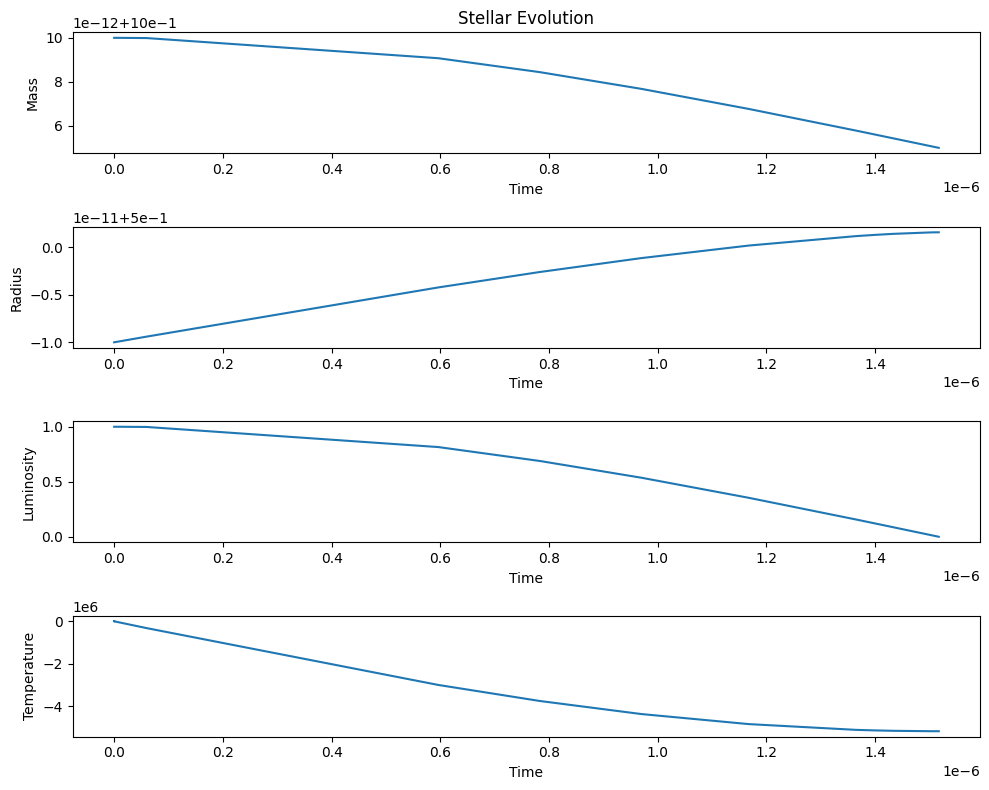

<ipython-input-12-9cfdbbdc0542>:81: RuntimeWarning: invalid value encountered in power
  convective_energy_transport = param4 * np.power((luminosity / np.maximum(temperature**4, epsilon)), 0.25)
<ipython-input-12-9cfdbbdc0542>:86: RuntimeWarning: invalid value encountered in sqrt
  dradius_dt = param2 * (mass / np.maximum(radius*2, epsilon)) * np.sqrt(luminosity / np.maximum(temperature*4, epsilon))


2/2 [==============================] - 0s 8ms/step


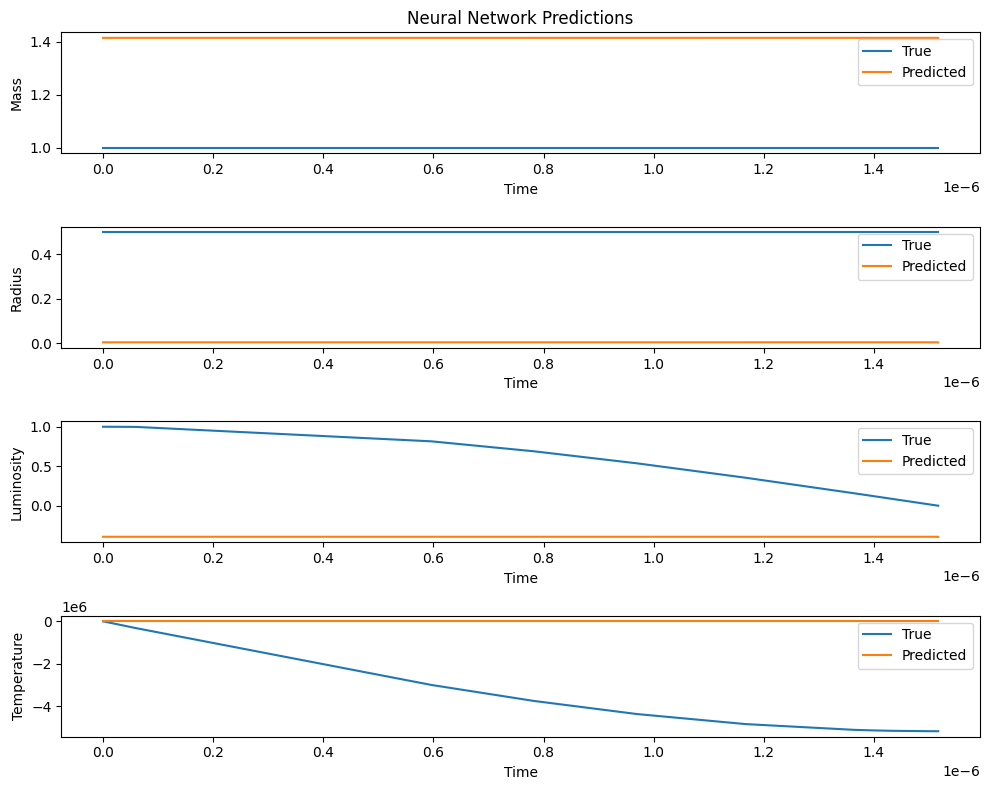

In [13]:
if __name__ == "__main__":
    se = stellar_evolution()
    se.main()